In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Please keep this notebook functionally at par with scripts/oncall/generate_report.py AND linearly runnable (no code with duplicated functionality; run all from this cell down should produce a report). Modify the parameters in `single_fitting_cycle` and `plot_trials` per customizations

In [13]:
import numpy as np
import pandas as pd

import datetime

import copy
import json
import time
import os


import sys
sys.path.append('../../')

from data.dataloader import Covid19IndiaLoader
from data.processing import get_data
from data.processing import get_dataframes_cached

from models.seir import SEIR_Testing, SEIRHD, SEIR_Movement, SEIR_Movement_Testing

from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.sensitivity import calculate_sensitivity_and_plot
from main.seir.forecast import get_forecast, forecast_all_trials, trials_to_df, scale_up_testing_and_forecast
from main.seir.forecast import create_all_csvs, create_decile_csv, create_region_csv, write_csv
from main.seir.uncertainty import MCMCUncertainty
from utils.create_report import create_report
from utils.enums import Columns
from utils.loss import Loss_Calculator
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

In [14]:
t = time.time()
output_folder = f'../../reports/{t}'

## Params

In [15]:
date_of_interest = '2020-07-31'
forecast_days = 54
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
folder = str(now)
ktrials = 10
model=SEIRHD

In [16]:
predictions_dict = {}

In [17]:
mcmc_cfg = json.load(open('../../uncertainty/cfg/testing.json'))

## Select Districts to fit on

In [18]:
state, district = ('Maharashtra', 'Mumbai')

## Perform M1 and M2 fits

Performing m1 fit ..
fetching from athenadb...
../../cache/dataframes_ts_12082020_athena.pkl


/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


104 121
Smoothing 6191 recovered between 2020-05-28 and 2020-04-11 (47) days in a weighted-mag manner
Smoothing 3139 recovered between 2020-06-14 and 2020-04-11 (64) days in a weighted-mag manner
Smoothing 915 recovered between 2020-06-15 and 2020-04-11 (65) days in a weighted-mag manner
Smoothing 2434 recovered between 2020-06-23 and 2020-06-15 (8) days in a weighted-mag manner
Smoothing 2141 recovered between 2020-06-24 and 2020-06-15 (9) days in a weighted-mag manner
Smoothing 5903 recovered between 2020-07-01 and 2020-05-28 (34) days in a weighted-mag manner
Smoothing 917 deceased between 2020-06-15 and 2020-04-11 (65) days in a weighted-mag manner

splitting data ..
splitting data ..
train
           date        state district  total_infected  hospitalised  \
105 2020-07-29  maharashtra   mumbai   112122.142857  20926.142857   
106 2020-07-30  maharashtra   mumbai   113172.857143  20732.428571   
107 2020-07-31  maharashtra   mumbai   114214.571429  20551.571429   
108 2020-08-01 

  0%|          | 4/1000 [00:00<00:26, 37.51it/s]

Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 9238561266563.428,
    'I_hosp_ratio': 4636539636697.115,
    'P_fatal': 30282506740821.88,
    'P_severe': 7458767891346.621,
    'R0': 6139521891792.447,
    'T_inc': 1252797328990.4504,
    'T_inf': 2076568496419.3333,
    'T_recov_fatal': 15963966952068.338,
    'T_recov_severe': 8362860788440.736,
    'intervention_amount': 12140877882630.896,
    'sigma': 8006878516297.897}


100%|██████████| 1000/1000 [00:21<00:00, 46.68it/s]


best parameters
 defaultdict(None, {'R0': 4.746888273690451, 'T_inc': 4.539871255642014, 'T_inf': 3.633871096706334, 'T_recov_fatal': 26.24322654289353, 'T_recov_severe': 10.541247501674535, 'P_severe': 0.6107767533738585, 'P_fatal': 0.044406951161533446, 'intervention_amount': 0.3756747938467744, 'E_hosp_ratio': 0.18933730894764356, 'I_hosp_ratio': 0.5635381794697368, 'sigma': 0.8430688117561084})


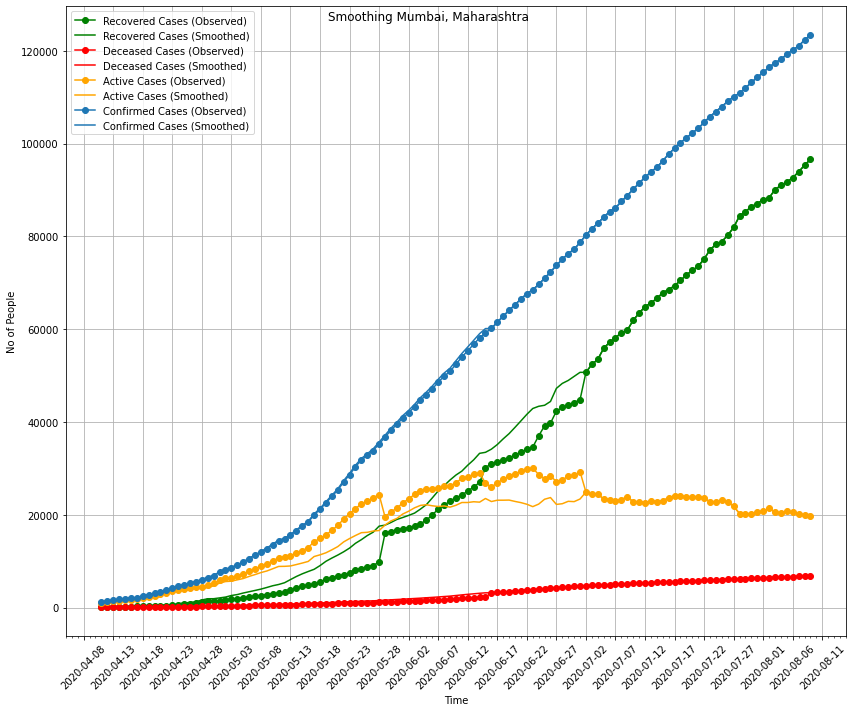

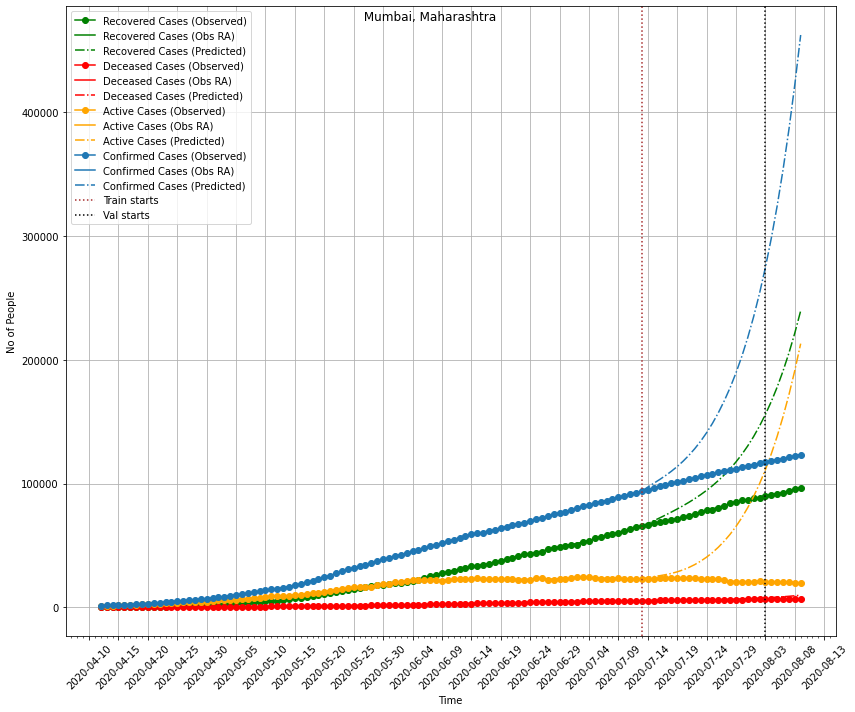

In [19]:
predictions_dict['m1'] = single_fitting_cycle(
    state, district, train_period=21, val_period=7, num_evals=1000,
    data_from_tracker=False, initialisation='intermediate', model=model, use_mcmc=True, mcmc_config=mcmc_cfg, 
    smooth_jump=True,
    which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

Performing m2 fit ..
fetching from athenadb...
../../cache/dataframes_ts_13082020_athena.pkl
pulling from source


/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


104 122
Smoothing 6191 recovered between 2020-05-28 and 2020-04-11 (47) days in a weighted-mag manner
Smoothing 3139 recovered between 2020-06-14 and 2020-04-11 (64) days in a weighted-mag manner
Smoothing 915 recovered between 2020-06-15 and 2020-04-11 (65) days in a weighted-mag manner
Smoothing 2434 recovered between 2020-06-23 and 2020-06-15 (8) days in a weighted-mag manner
Smoothing 2141 recovered between 2020-06-24 and 2020-06-15 (9) days in a weighted-mag manner
Smoothing 5903 recovered between 2020-07-01 and 2020-05-28 (34) days in a weighted-mag manner
Smoothing 917 deceased between 2020-06-15 and 2020-04-11 (65) days in a weighted-mag manner

splitting data ..
splitting data ..
train
           date        state district  total_infected  hospitalised  \
113 2020-08-06  maharashtra   mumbai   120246.571429  20274.857143   
114 2020-08-07  maharashtra   mumbai   121232.428571  20081.142857   
115 2020-08-08  maharashtra   mumbai   122331.000000  19932.000000   
116 2020-08-09 

  1%|          | 6/1000 [00:00<00:17, 58.05it/s]

Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 16945933752349.037,
    'I_hosp_ratio': 11734799482301.42,
    'P_fatal': 9506167955015.31,
    'P_severe': 7336510228160.97,
    'R0': 8543763140899.031,
    'T_inc': 780295689923.5437,
    'T_inf': 4290539019093.913,
    'T_recov_fatal': 9268238499062.021,
    'T_recov_severe': 7275258131922.569,
    'intervention_amount': 20335709294826.645,
    'sigma': 11845920459332.812}


100%|██████████| 1000/1000 [00:15<00:00, 66.55it/s]


best parameters
 defaultdict(None, {'R0': 4.989843346215262, 'T_inc': 4.25213856999438, 'T_inf': 3.9257237811102534, 'T_recov_fatal': 8.880118301962439, 'T_recov_severe': 10.577056125231628, 'P_severe': 0.5350956910067433, 'P_fatal': 0.18598686249433016, 'intervention_amount': 0.17585885116235772, 'E_hosp_ratio': 0.33894351843792003, 'I_hosp_ratio': 0.07536384422819577, 'sigma': 0.726000828770296})


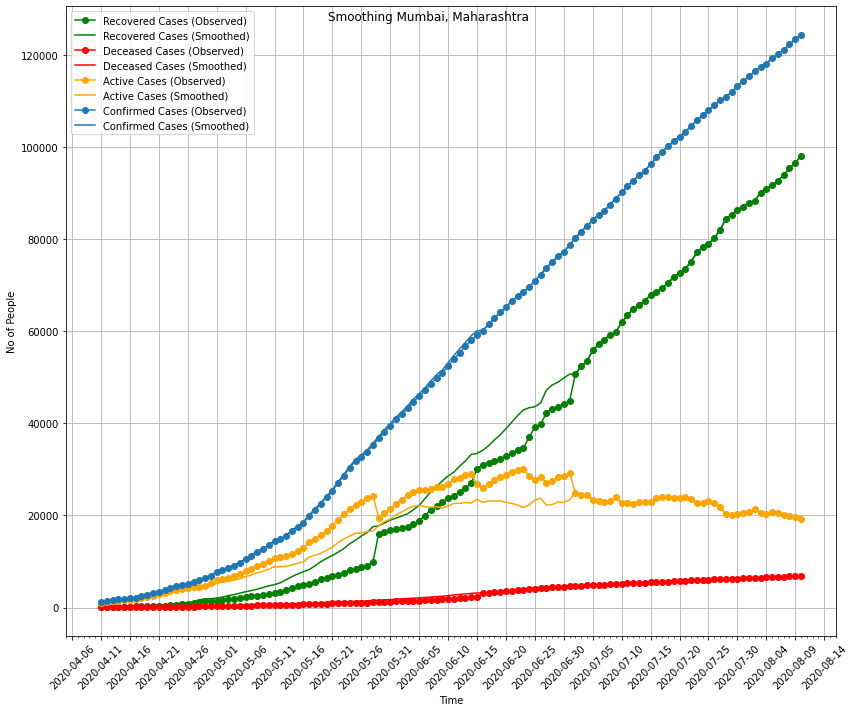

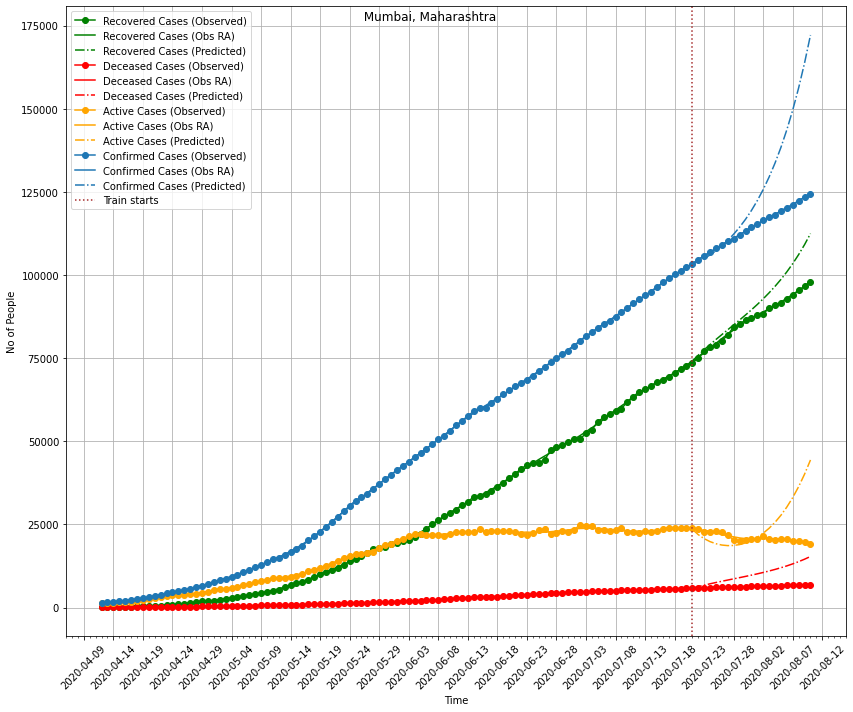

In [20]:
predictions_dict['m2'] = single_fitting_cycle(
    state, district, train_period=21, val_period=0, num_evals=1000,
    data_from_tracker=False, initialisation='intermediate', model=model, use_mcmc=True, mcmc_config=mcmc_cfg, 
    smooth_jump=True,
    which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

In [21]:
predictions_dict['state'] = state
predictions_dict['dist'] = district
predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
predictions_dict['datasource'] = 'covid19api' if predictions_dict['m1']['data_from_tracker'] else 'municipality'
predictions_dict['variable_param_ranges'] = predictions_dict['m1']['variable_param_ranges']
predictions_dict['data_last_date'] = predictions_dict['m2']['data_last_date']

## Fitting Loss

### M1 Loss

In [22]:
predictions_dict['m1']['df_loss']

,train,val
hospitalised,110.887,679.81
total_infected,38.5854,198.655
deceased,3.2877,29.4801
recovered,23.3094,107.808


### M2 Loss

In [23]:
predictions_dict['m2']['df_loss']

,train
hospitalised,29.0432
total_infected,10.0144
deceased,56.5912
recovered,4.87348


## Sensitivity Plots

In [24]:
# predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, which_fit='m1')
# predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, which_fit='m2')

## Plot Forecasts

getting forecasts ..


5it [00:00, 48.55it/s]

getting forecasts ..


1000it [00:22, 45.00it/s]
6it [00:00, 53.26it/s]

getting forecasts ..


1000it [00:19, 50.71it/s]


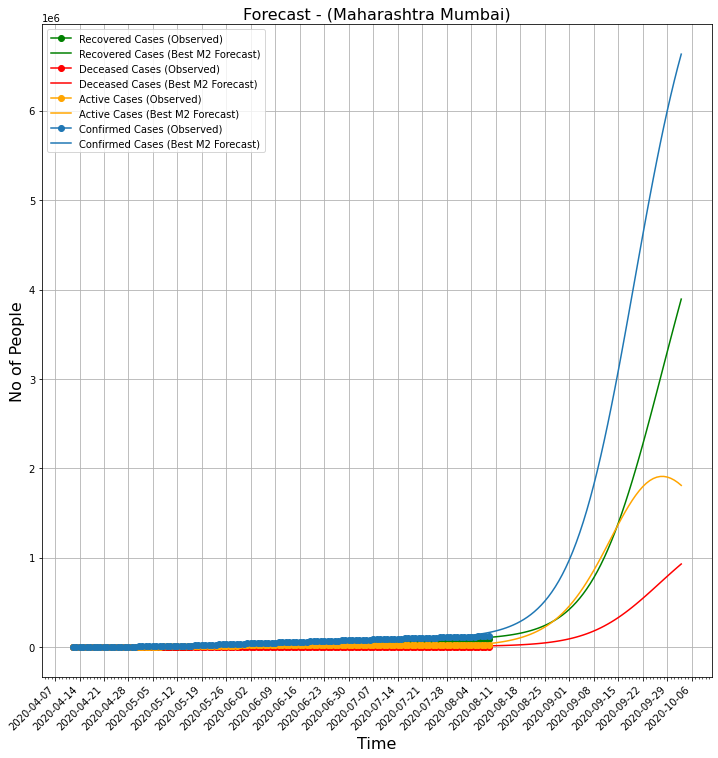

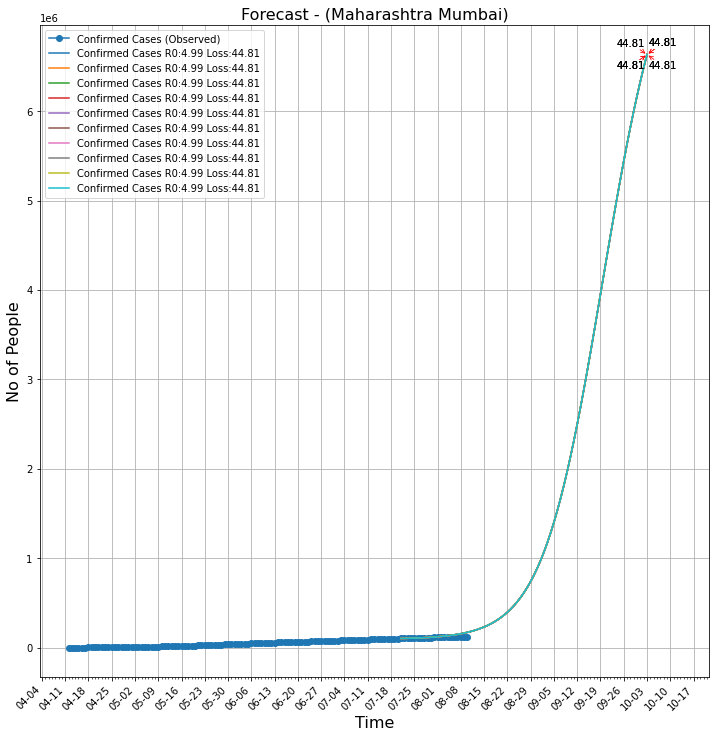

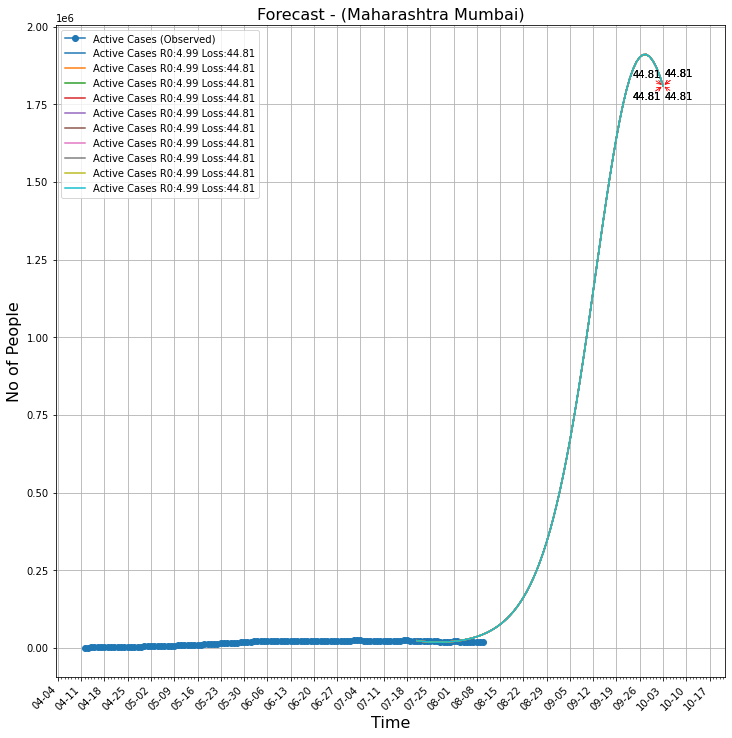

In [25]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', days=forecast_days)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, (state, district), error_bars=False)

trials_processed = forecast_all_trials(predictions_dict, train_fit='m1', forecast_days=forecast_days)
predictions_dict['m1']['trials_processed'] = trials_processed
predictions_dict['m1']['all_trials'] = trials_to_df(trials_processed, column=Columns.confirmed)
trials_processed = forecast_all_trials(predictions_dict, train_fit='m2', forecast_days=forecast_days)
predictions_dict['m2']['trials_processed'] = trials_processed
predictions_dict['m2']['all_trials'] = trials_to_df(trials_processed, column=Columns.confirmed)
kforecasts = plot_top_k_trials(
    predictions_dict,
    train_fit='m2',
    trials_processed=predictions_dict['m2']['trials_processed'], 
    k=ktrials,
    which_compartments=[Columns.confirmed, Columns.active])
predictions_dict['m2']['plots']['forecast_confirmed_topk'] = kforecasts[Columns.confirmed]
predictions_dict['m2']['plots']['forecast_active_topk'] = kforecasts[Columns.active]

In [35]:
predictions_dict['m2']['trials_processed']['losses']

array([4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
      

In [26]:
trials_processed_df = pd.DataFrame(list(predictions_dict['m2']['trials_processed']['params']))

In [27]:
for column in trials_processed_df.columns:
    print (column, trials_processed_df[column].min() )

R0 1.6896479222564345
T_inc 4.002366382826652
T_inf 3.071136312832217
T_recov_fatal 8.880118301962439
T_recov_severe 9.677987130898813
P_severe 0.5350956910067433
P_fatal 0.06303344604106831
intervention_amount 0.10300059878981162
E_hosp_ratio 0.01957273962551391
I_hosp_ratio 0.07446767111493872
sigma 0.17412104229725023


In [28]:
predictions_dict['m2']['trials_processed']['losses']

array([4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
       4.48068580e+01, 4.48068580e+01, 4.48068580e+01, 4.48068580e+01,
      

In [39]:
predictions_dict['m2']['best_params']

defaultdict(None,
            {'R0': 4.989843346215262,
             'T_inc': 4.25213856999438,
             'T_inf': 3.9257237811102534,
             'T_recov_fatal': 8.880118301962439,
             'T_recov_severe': 10.577056125231628,
             'P_severe': 0.5350956910067433,
             'P_fatal': 0.18598686249433016,
             'intervention_amount': 0.17585885116235772,
             'E_hosp_ratio': 0.33894351843792003,
             'I_hosp_ratio': 0.07536384422819577,
             'sigma': 0.726000828770296})

## Uncertainty

In [29]:
uncertainty = MCMCUncertainty(predictions_dict, date_of_interest)

## Uncertainty Forecasts

In [30]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']

In [31]:
predictions_dict['m2']['deciles'] = uncertainty_forecasts

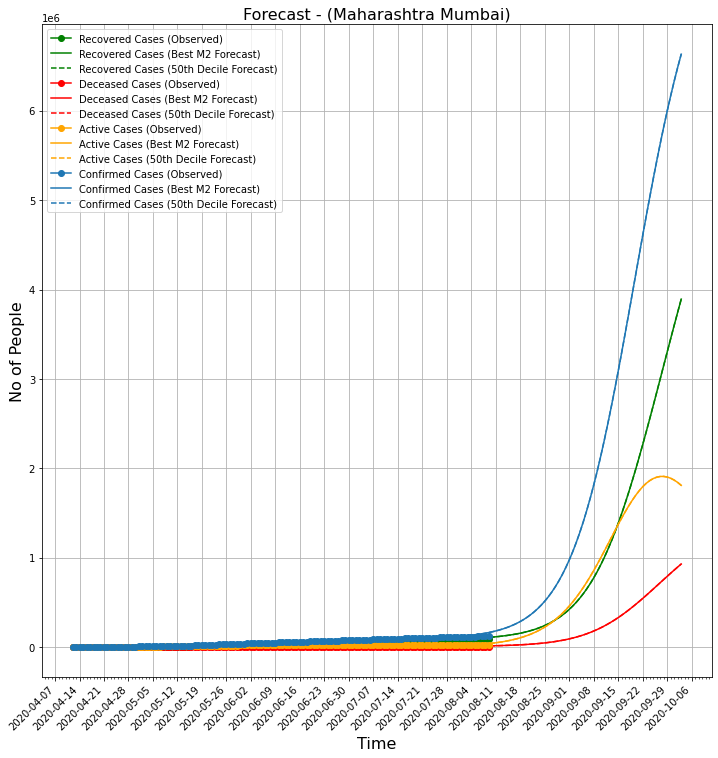

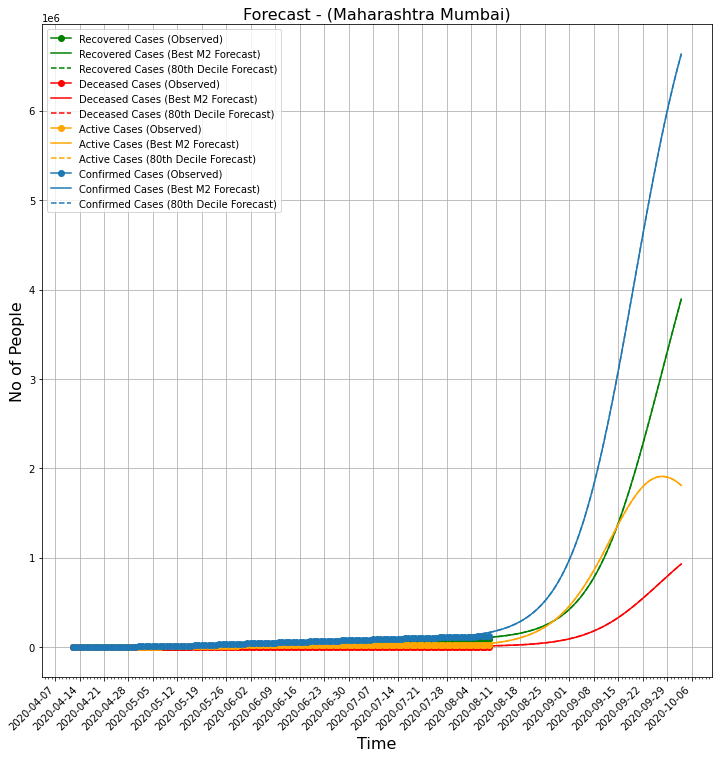

In [32]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, (state, district), fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, (state, district), fits_to_plot=['best', 80], error_bars=False)

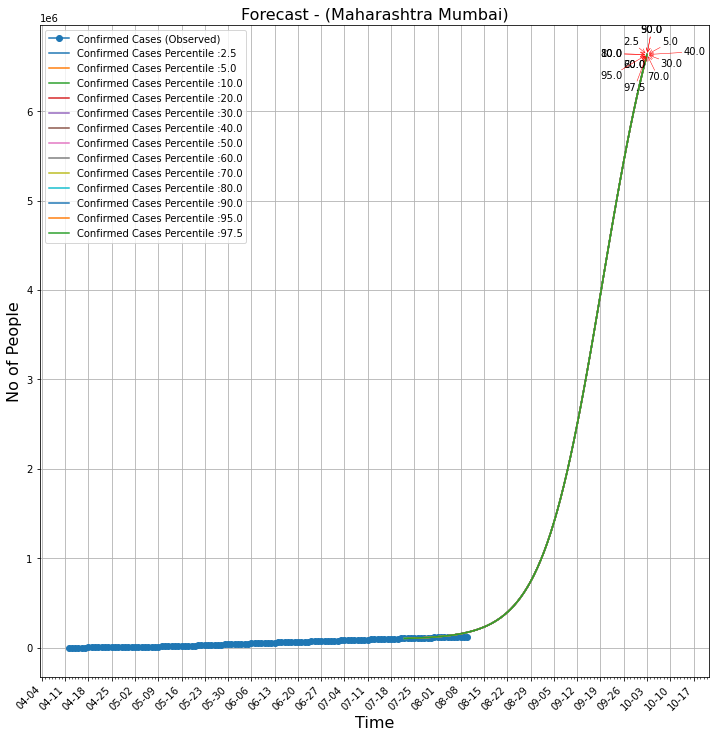

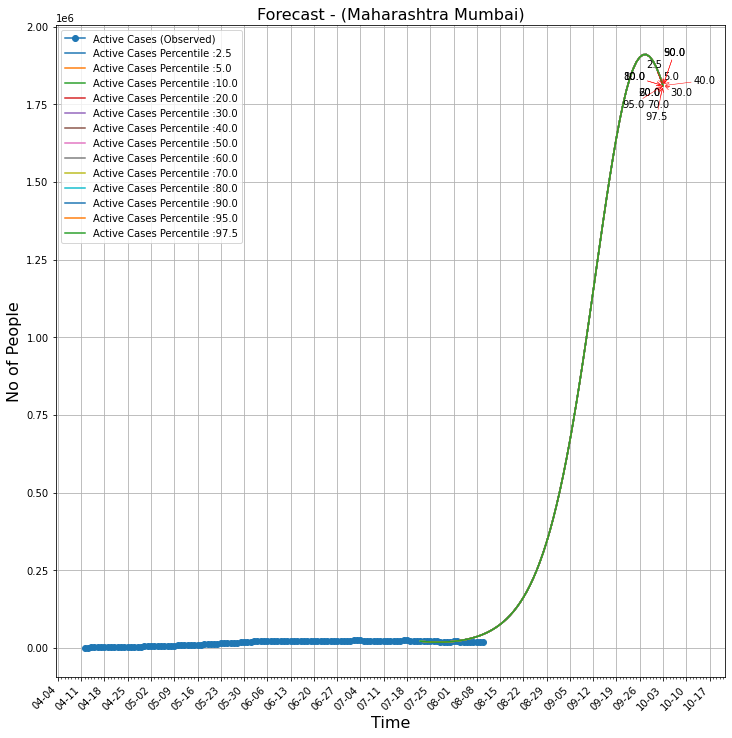

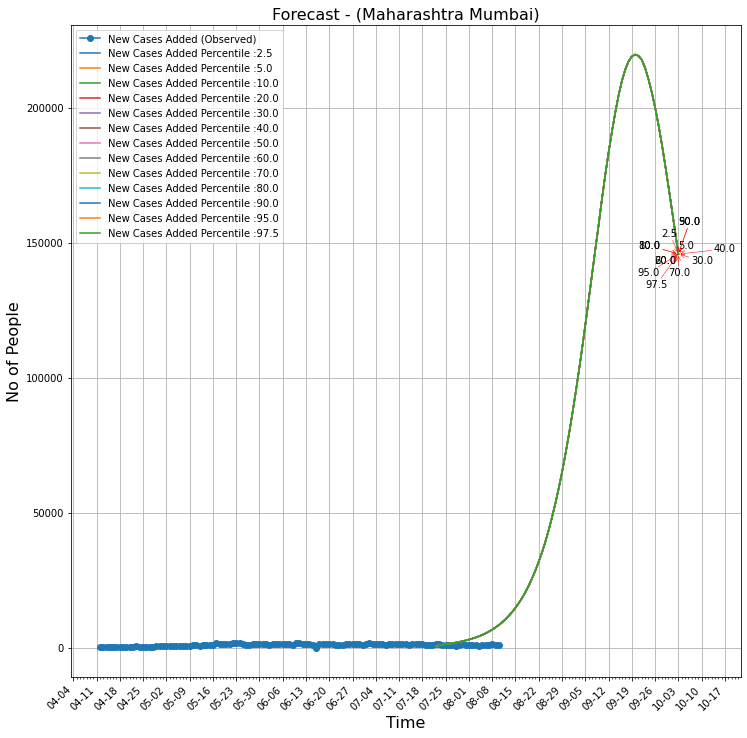

In [33]:
plots = plot_ptiles(predictions_dict, which_compartments=[Columns.confirmed, Columns.active, Columns.daily_cases])
predictions_dict['m2']['plots']['forecast_confirmed_ptiles'] = plots[Columns.confirmed]
predictions_dict['m2']['plots']['forecast_active_ptiles'] = plots[Columns.active]
predictions_dict['m2']['plots']['forecast_new_cases_ptiles'] = plots[Columns.daily_cases]

## What-ifs

In [34]:
scaling_factors = [1.2, 1.5, 1.8, 2.0]
scenario_on_which_df = 50
for factor in scaling_factors:
    ppfactor = str(factor).replace('.', '')
    predictions_dict['m2']['forecasts'][f'testing_{ppfactor}'] = scale_up_testing_and_forecast(predictions_dict, model=model, 
                                                                                               scenario_on_which_df=scenario_on_which_df, 
                                                                                               testing_scaling_factor=factor)

NameError: name 'get_variable_param_ranges' is not defined

In [ ]:
predictions_dict['m2']['plots']['whatifs_testing'] = plot_forecast(predictions_dict, (state, district), 
                                                                   fits_to_plot=['testing_12', 'testing_15', 'testing_18',
                                                                                 'testing_20'], 
                                                                   error_bars=False)

## Create Report

In [ ]:
# create_report(predictions_dict, ROOT_DIR=output_folder)
# predictions_dict['m1']['all_trials'].to_csv(os.path.join(output_folder, 'm1-trials.csv'))
# predictions_dict['m2']['all_trials'].to_csv(os.path.join(output_folder, 'm2-trials.csv'))

## Create and Save Output CSV

In [ ]:
# df_final = create_all_csvs(predictions_dict)

In [ ]:
# write_csv(df_final, filename=os.path.join(output_folder, f'output-{t}.csv'))

In [ ]:
# df_output = create_decile_csv(predictions_dict, region='Mumbai', regionType='district')

In [ ]:
# write_csv(df_output, filename=os.path.join(output_folder, f'output-format-2-{t}.csv'))